# XGBoost Performance Comparison 

In this example we will train a XGBoost model and predict the results to show off Intel's optimizations for XGBoost used for increased performance. Intel optimized XGBoost is shipped as a part of the Intel® oneAPI AI Analytics Toolkit.

This example is a Jupyter Notebook version of a XGBoost example seen in this Medium blog using the popular Higgs dataset: 
https://medium.com/intel-analytics-software/new-optimizations-for-cpu-in-xgboost-1-1-81144ea21115

In this example, we will use a dataset with particle features and functions of those features **to distinguish between a signal process which produces Higgs bosons (1) and a background process which does not (0)**. The Higgs boson is a basic particle in the standard model produced by the quantum excitation of the Higgs field, named after physicist Peter Higgs.

## Example Environment Creation

This example is executed in two Anaconda environments. 

The first environment is the latest [Intel® oneAPI AI Analytics Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi/ai-analytics-toolkit.html) base environment, which includes data analytics and machine learning workflows and Intel optimizations for XGboost. See [here](https://software.intel.com/content/www/us/en/develop/articles/installing-ai-kit-with-conda.html) for more installation information.

The second environment is a clone of the first environment using commands:

`conda clone --name xgb0.81 --clone aikit-base-env-name`

`conda activate xgb0.81`

`conda remove xgboost`

`pip install xgboost==0.81`

Run this performance demo in both environments, **saving the visualization cell until after both runs as instructed later in this demo.**

## Importing and Organizing Data

Let's start by **importing** all necessary data and packages.


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
import pandas as pd
import sys
import xgboost as xgb
import time

Now let's **load** in the Higgs dataset and **organize** it as necessary to work with our model. You can opt to remove this cell and add your own data as you see fit.

In [2]:
def load_higgs(nrows_train, nrows_test, dtype=np.float32):
    if not os.path.isfile("./HIGGS.csv.gz"):
        print("Loading data set...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"
        myfile = requests.get(url)
        with open('./HIGGS.csv.gz', 'wb') as f:
            f.write(myfile.content)
    print("Reading data set...")
    data = pd.read_csv("./HIGGS.csv.gz", delimiter=",", header=None, compression="gzip", dtype=dtype, nrows=nrows_train+nrows_test)
    print("Pre-processing data set...")
    data = data[list(data.columns[1:])+list(data.columns[0:1])]
    n_features = data.shape[1]-1
    train_data = np.ascontiguousarray(data.values[:nrows_train,:n_features])
    train_label = np.ascontiguousarray(data.values[:nrows_train,n_features])
    test_data = np.ascontiguousarray(data.values[nrows_train:nrows_train+nrows_test,:n_features])
    test_label = np.ascontiguousarray(data.values[nrows_train:nrows_train+nrows_test,n_features])
    n_classes = len(np.unique(train_label))
    print(sys.getsizeof(train_data))
    return train_data, train_label, test_data, test_label, n_classes, n_features 

We will run this model and prediction using 10,000 rows of the Higgs dataset.

In [3]:
train_data, train_label, test_data, test_label, n_classes, n_features = load_higgs(10000, 10000)

Reading data set...
Pre-processing data set...
1120112


## Training the Model

**Fitting and training the model** using the training dataset, which consists of particle features and functions of those features to help discern between a signal process that produces Higgs bosons and background process.

In [4]:
# Set XGBoost parameters
xgb_params = {
    'verbosity':                    0,
    'alpha':                        0.9,
    'max_bin':                      256,
    'scale_pos_weight':             2,
    'learning_rate':                0.1,
    'subsample':                    1,
    'reg_lambda':                   1,
    "min_child_weight":             0,
    'max_depth':                    8,
    'max_leaves':                   2**8,
    'objective':                    'binary:logistic',
    'predictor':                    'cpu_predictor',
    'tree_method':                  'hist',
    'n_estimators':                1000
}

# Train the model
t0 = time.time() #begin timer
model_xgb= xgb.XGBClassifier(**xgb_params)
model_xgb.fit(train_data, train_label)

[10:15:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


XGBClassifier(alpha=0.9, max_bin=256, max_depth=8, max_leaves=256,
              min_child_weight=0, n_estimators=1000, predictor='cpu_predictor',
              scale_pos_weight=2, tree_method='hist', verbosity=0)

## Making A Prediction

Now let's **make a prediction,** using Intel optimized XGBoost*, for increased performance. whether the particles in the dataset have a signal process which produces Higgs bosons or a background process which does not produce them.

In [5]:
#predict label using test data
result_predict_xgb_test = model_xgb.predict(test_data)
t1 = time.time() #end timer

## Accuracy

Now let's **check the accuracy** of our model by comparing our prediction to the correct classification of the particles.

In [6]:
# Check model accuracy
acc = np.mean(test_label == result_predict_xgb_test)
print(acc)

0.6937


## Training + Prediction Time

In [7]:
xgb_total = t1-t0

### Visualization

**Directions:** 

If ./perf_numbers.csv is already created from a previous comparison of the two environment runs (aikit-base and XGBoost 0.81), remove it.

Run the following cell in both environments to generate the dataframe that will be used for visualization (run demo in one environment, then switch to the other environment and run it again.).

In [8]:
filename = "./perf_numbers.csv"

xgb_ver= xgb.__version__

if not os.path.isfile(filename):
    df = pd.DataFrame([[xgb_ver,xgb_total]], columns = ["XGBoost Version",  "Time in Sec"])
    df.to_csv(filename, index=False) 
else:
    df = pd.read_csv(filename)
    if not df.shape[0]==2:
        df2 = pd.DataFrame([[xgb_ver,xgb_total]], columns = ["XGBoost Version",  "Time in Sec"])
        df = df.append(df2, ignore_index=True)

**Only run the following cells after running the demo in both environments.** This will generate the performance visualization.

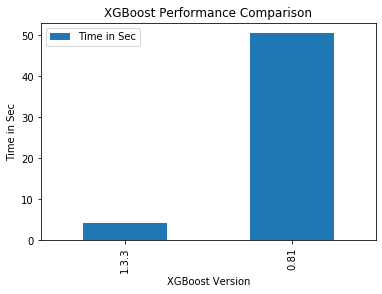

In [9]:
if ((os.path.isfile(filename)) and (df.shape[0]==2)):
    left = [1,2]
    df.plot(x='XGBoost Version', y='Time in Sec', kind='bar',width = 0.5)
    plt.xlabel('XGBoost Version'); plt.ylabel('Time in Sec'); plt.title('XGBoost Performance Comparison')
    plt.show()

In [10]:
df

,XGBoost Version,Time in Sec
0,1.3.3,4.102728
1,0.81,50.546151


In [11]:
print("[CODE_SAMPLE_COMPLETED_SUCCESFULLY]")

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
